In [ ]:
##Script for upsampling##


# source_folder = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset - Copy\train'

# data = {
#     'count': [814, 271, 316, 311, 424, 441, 775],
#     'class': ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
# }

# df = pd.DataFrame(data)

# majority_class = df.loc[df['count'].idxmax()]['class']
# majority_count = df.loc[df['count'].idxmax()]['count']

# desired_total_images = 2000

# for index, row in df.iterrows():
#     source_class_folder = os.path.join(source_folder, row['class'])
#     image_files = os.listdir(source_class_folder)

#     current_count = len(image_files)

#     images_to_generate = desired_total_images - current_count

#     for i in range(images_to_generate):
#         random_image_filename = np.random.choice(image_files)
#         random_image_path = os.path.join(source_class_folder, random_image_filename)

#         random_image = cv2.imread(random_image_path)
        
#         h, w, _ = random_image.shape
#         x = 0 if w <= 224 else np.random.randint(0, w - 224)
#         y = 0 if h <= 224 else np.random.randint(0, h - 224)
#         cropped_image = random_image[y:y+224, x:x+224]

#         output_path = os.path.join(source_class_folder, f'{row["class"]}_{current_count + i}.jpg')
#         cv2.imwrite(output_path, cropped_image)

#     print(f"Generated {images_to_generate} augmented images for {row['class']}")

# print("Data augmentation completed.")


In [1]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.utils import class_weight
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Conv2D, Dropout, Dense

In [2]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset - Copy'

img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
    horizontal_flip = True,                         
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

datagen2 = ImageDataGenerator(rescale=1./255, horizontal_flip = False, validation_split=0.2)

datagen3 = ImageDataGenerator(rescale=1./255, horizontal_flip = False)

train_images = datagen.flow_from_directory(
                                          os.path.join(data_dir, 'train'),
                                          target_size = img_size,
                                          class_mode = "categorical",
                                          shuffle = True,
                                          batch_size = batch_size,
                                          subset = 'training')

valid_images = datagen2.flow_from_directory(os.path.join(data_dir, 'train'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size,
                                           subset = 'validation')
test_images = datagen3.flow_from_directory(os.path.join(data_dir, 'test'),
                                           target_size = img_size,
                                           class_mode = "categorical",
                                           shuffle = False,
                                           batch_size = batch_size)

Found 14000 images belonging to 7 classes.
Found 2800 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization() (x)
x = Dense(1024, activation = "relu") (x)
x = Dropout(0.3) (x)
x = Dense(512, activation = "relu") (x)
x = Dropout(0.25) (x)
x = Dense(128, activation = "relu") (x)
x = Dropout(0.15) (x)
x = Dense(64, activation = "relu") (x)
x = Dropout(0.15) (x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[Precision(name='precision'), Recall(name='recall'), 'accuracy']
)

early_stopping = EarlyStopping(monitor="val_accuracy", patience  = 5,verbose=1, restore_best_weights=True)

history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size=batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
438/438 [==============================] - 136s 297ms/step - loss: 0.7799 - precision: 0.8275 - recall: 0.6495 - accuracy: 0.7291 - val_loss: 0.4156 - val_precision: 0.9021 - val_recall: 0.8225 - val_accuracy: 0.8639
Epoch 2/100
438/438 [==============================] - 129s 295ms/step - loss: 0.4412 - precision: 0.9000 - recall: 0.8273 - accuracy: 0.8626 - val_loss: 0.2310 - val_precision: 0.9494 - val_recall: 0.9054 - val_accuracy: 0.9229
Epoch 3/100
438/438 [==============================] - 130s 296ms/step - loss: 0.3286 - precision: 0.9235 - recall: 0.8724 - accuracy: 0.8971 - val_loss: 0.2428 - val_precision: 0.9328 - val_recall: 0.9125 - val_accuracy: 0.9218
Epoch 4/100
438/438 [==============================] - 131s 299ms/step - loss: 0.2764 - precision: 0.9328 - recall: 0.8949 - accuracy: 0.9134 - val_loss: 0.1842 - val_precision: 0.9562 - val_recall: 0.9268 - val_accuracy: 0.9414
Epoch 5/100
438/438 [==============================] - 137s 313ms/step - loss: 0.239

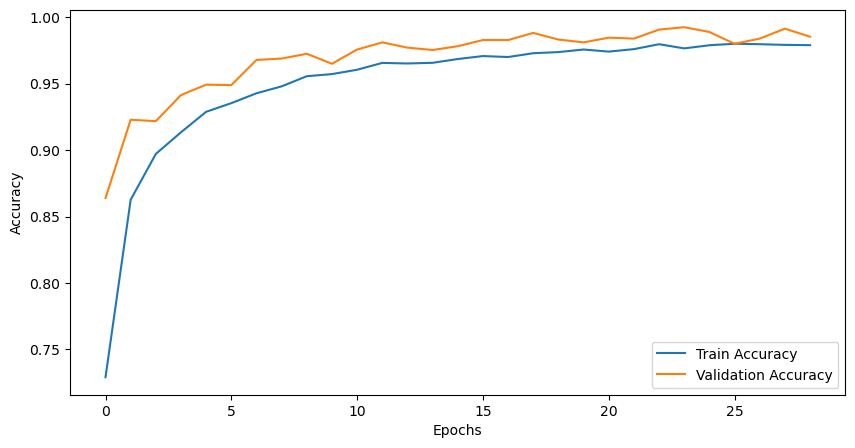

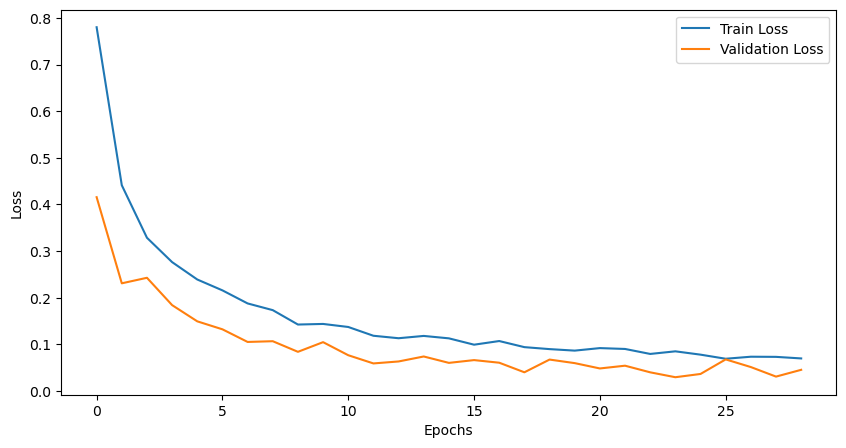

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

26/26 [==============================] - 1s 41ms/step - loss: 0.3882 - precision: 0.9396 - recall: 0.9188 - accuracy: 0.9287
Test Loss: 0.3881571292877197
Test Accuracy: 0.9396226406097412
26/26 [==============================] - 2s 40ms/step
Classification Report:
                   precision    recall  f1-score   support

            Audi       0.92      0.93      0.93       199
   Hyundai Creta       0.93      0.82      0.87        67
Mahindra Scorpio       0.96      0.92      0.94        75
     Rolls Royce       0.88      0.82      0.85        74
           Swift       0.90      0.93      0.91       102
     Tata Safari       0.95      0.96      0.96       106
   Toyota Innova       0.95      0.98      0.97       190

        accuracy                           0.93       813
       macro avg       0.93      0.91      0.92       813
    weighted avg       0.93      0.93      0.93       813



<AxesSubplot:>

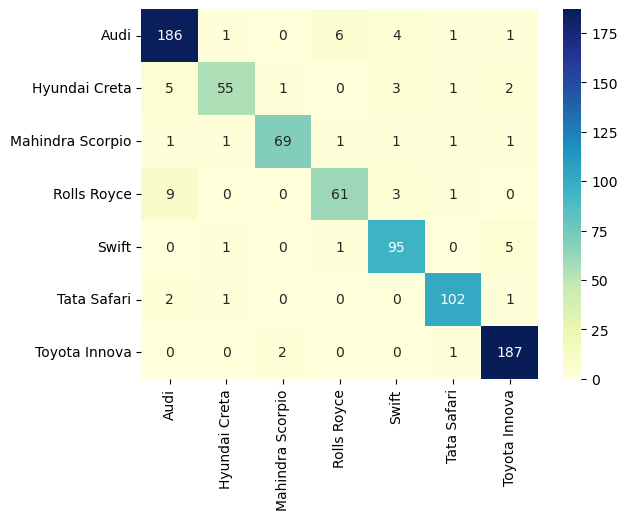

In [5]:
true_classes = test_images.classes
class_names = list(test_images.class_indices.keys())
test_evaluation = model.evaluate(test_images)
test_loss = test_evaluation[0]
test_accuracy = test_evaluation[1]

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
confusion_mat = confusion_matrix(true_classes, test_predictions_classes)
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)

import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index=class_names, columns=class_names)
sn.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")

In [6]:
model.save("car_classification_model.h5")
print("Model saved successfully.")

Model saved successfully.


In [7]:
print(class_names)

['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
